In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
def create_df_train(my_dir):
    df = pd.DataFrame(columns=['id'])
    for scene in os.listdir(my_dir):
        for ele in scene:
            if id!='.DS_Store':
                df = df.append(pd.DataFrame([[f"{my_dir}{id}"]],columns=['id','']), ignore_index=True)
    return df

In [6]:
create_df_train("data/seg_train/seg_train")

,id
0,data/seg_train/seg_trainforest
1,data/seg_train/seg_trainbuildings
2,data/seg_train/seg_trainglacier
3,data/seg_train/seg_trainstreet
4,data/seg_train/seg_trainmountain
5,data/seg_train/seg_trainsea


In [5]:
# Import train data with id and class labels
train_id_labels = pd.read_csv("data/data/train_labels.csv")
train_id_labels.head()

,id,class
0,data/seg_train/seg_train/forest/5109.jpg,forest
1,data/seg_train/seg_train/forest/14621.jpg,forest
2,data/seg_train/seg_train/forest/6366.jpg,forest
3,data/seg_train/seg_train/forest/4565.jpg,forest
4,data/seg_train/seg_train/forest/17472.jpg,forest


In [167]:
# Extract all possible classes
scene_list = np.array(os.listdir("data/seg_train/seg_train/"))
scene_list

array(['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea'],
      dtype='<U9')

In [168]:
# Import train data with id and class labels
train_id_labels = pd.read_csv("data/data/train_labels.csv")
train_id_labels.head()

,id,class
0,data/seg_train/seg_train/forest/5109.jpg,forest
1,data/seg_train/seg_train/forest/14621.jpg,forest
2,data/seg_train/seg_train/forest/6366.jpg,forest
3,data/seg_train/seg_train/forest/4565.jpg,forest
4,data/seg_train/seg_train/forest/17472.jpg,forest


In [169]:
# Import test data with id and class labels
test_id_labels = pd.read_csv("data/data/test_labels.csv")
test_id_labels.head()

,id,class
0,data/seg_test/seg_test/forest/23933.jpg,forest
1,data/seg_test/seg_test/forest/23728.jpg,forest
2,data/seg_test/seg_test/forest/24047.jpg,forest
3,data/seg_test/seg_test/forest/23700.jpg,forest
4,data/seg_test/seg_test/forest/24251.jpg,forest


In [170]:
# Extract train, test data with only class labels
labels_train = train_id_labels["class"].to_numpy()
labels_test = test_id_labels["class"].to_numpy()

In [171]:
# Change the train data class labels to be in an boolean of class form
boolean_labels_train = [label == scene_list for label in labels_train]
boolean_labels_train[:3]

[array([ True, False, False, False, False, False]),
 array([ True, False, False, False, False, False]),
 array([ True, False, False, False, False, False])]

In [172]:
# Change the test data class labels to be in an boolean of class form
boolean_labels_test = [label == scene_list for label in labels_test]
boolean_labels_test[:3]

[array([ True, False, False, False, False, False]),
 array([ True, False, False, False, False, False]),
 array([ True, False, False, False, False, False])]

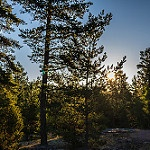

In [174]:
# Test by showing the image
from IPython.display import Image

Image(train_id_labels.iloc[:1,:1].values[0][0])

In [175]:
# Seperate the data into train and validation
X_train = list(train_id_labels["id"].values)
y_train = boolean_labels_train
X_val = list(test_id_labels["id"].values)
y_val = boolean_labels_test

In [176]:
IMG_SIZE = 224

def process_image(image_path,img_size=IMG_SIZE):
    """
    Take an image file path and turn image into a Tensor.
    """
    image = tf.io.read_file(image_path) # Read image file
    image = tf.image.decode_jpeg(image,channels=3) # Turn the image into 3 channels RGB
    image = tf.image.convert_image_dtype(image,tf.float32) # Turn the value 0-255 to 0-1
    image = tf.image.resize(image,size=[img_size,img_size]) # Resize the image to 224x224
    return image 

In [177]:
def get_image_label(image_path,label):
    """
    Take an image file path name and the associated label,
    process the image and return a tuple of (image,label)
    """
    image = process_image(image_path)
    return image,label

In [178]:
BATCH_SIZE = 32

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X) and lebel (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating testing data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only file path (no label)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is valid dataset, we don't have to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # file path, label
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [179]:
# Create training and validation data batches
train_data = create_data_batches(X=X_train,y=y_train)
val_data = create_data_batches(X=X_val,y=y_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


In [184]:
import matplotlib.pyplot as plt

def show_25_images(images,labels):
    """
    Display a plot of 25 images and their labels from a batch.
    """
    plt.figure(figsize=(15,10))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(scene_list[labels[i].argmax()])
        plt.axis("off")

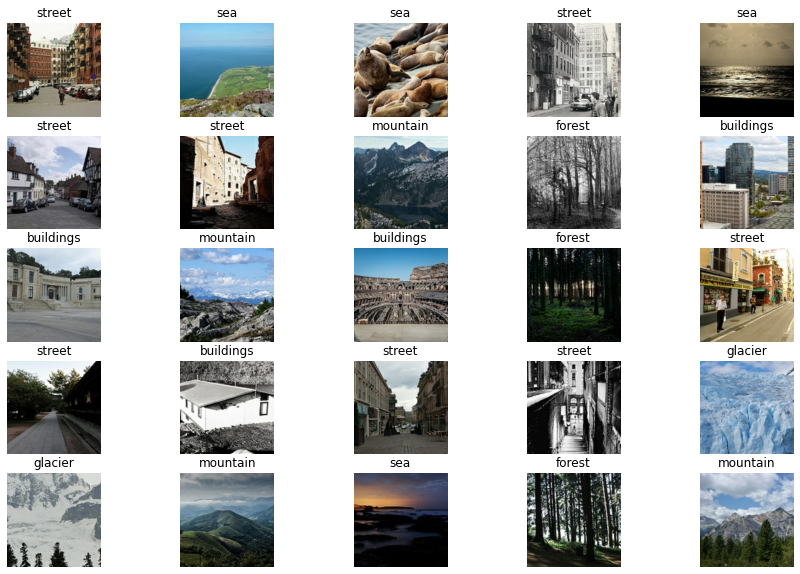

In [185]:
train_images,train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

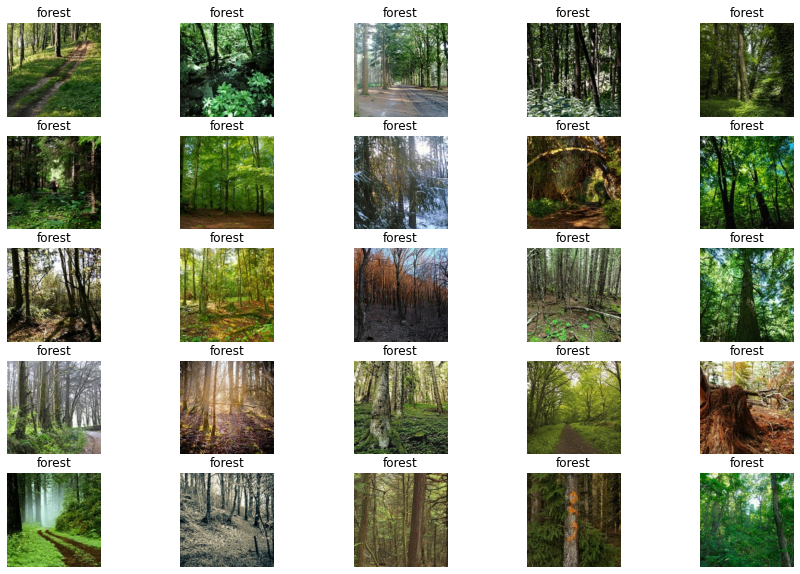

In [186]:
val_images,val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

In [187]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = 6
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    print(f"Building model with: {model_url}")
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1: Input layer
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax")]) # Layer 2: Output layer
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"])
    model.build(input_shape)
    return model

In [188]:
import datetime
def create_tensorboard_callback():
    logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [189]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)
NUM_EPOCHS = 3

In [190]:
def train_model():
    """
    Train a given model and return the trained version.
    """
    model = create_model() # Create a model
    model.summary()
    tensorboard = create_tensorboard_callback() # Create tensorboard callback
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping]) # Fit the model passing it the callback we created
    return model

In [191]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 6012      
Total params: 5,438,725
Trainable params: 6,012
Non-trainable params: 5,432,713
_________________________________________________________________
Epoch 1/3
439/439 [==============================] - 366s 827ms/step - loss: 0.4932 - accuracy: 0.8233 - val_loss: 0.2409 - val_accuracy: 0.9123
Epoch 2/3
439/439 [==============================] - 350s 798ms/step - loss: 0.2174 - accuracy: 0.9193 - val_loss: 0.2281 - val_accuracy: 0.9143
Epoch 3/3
439/439 [==============================] - 354s 806ms/step - loss: 0.1904 - accuracy: 0.9327 - val_loss: 0.26

In [192]:
model.save("scene-classifier.h5")

In [193]:
def create_df(my_dir):
    df = pd.DataFrame(columns=['id'])
    for id in os.listdir(my_dir):
        if id!='.DS_Store':
            df = df.append(pd.DataFrame([[f"{my_dir}{id}"]],columns=['id']), ignore_index=True)
    return df

In [194]:
test = create_df("data/seg_pred/seg_pred/")
test.head()

,id
0,data/seg_pred/seg_pred/63.jpg
1,data/seg_pred/seg_pred/24084.jpg
2,data/seg_pred/seg_pred/13628.jpg
3,data/seg_pred/seg_pred/3578.jpg
4,data/seg_pred/seg_pred/10321.jpg


In [195]:
X_test = list(test["id"].values)

In [196]:
test_data = create_data_batches(X=X_test,test_data=True)

Creating testing data batches...


In [197]:
predicted = model.predict(test_data)

In [198]:
np.round(predicted)

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

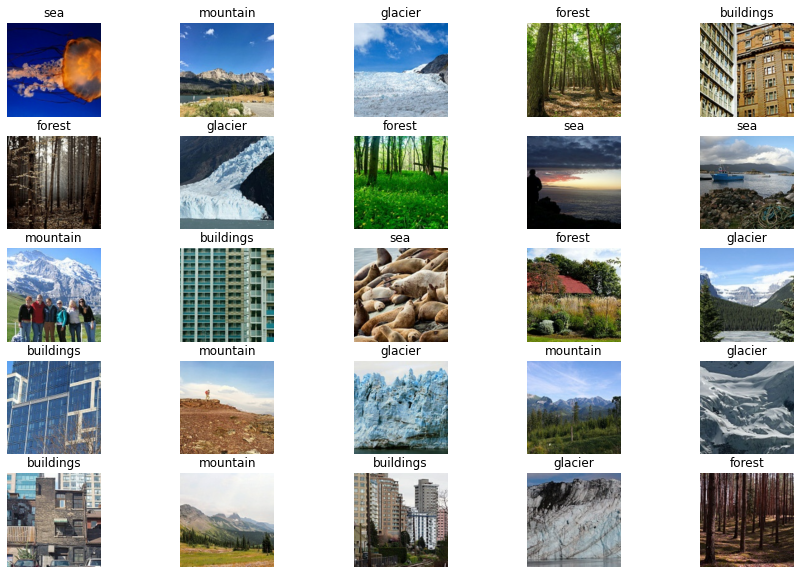

In [199]:
test_data = next(test_data.as_numpy_iterator())
show_25_images(test_data,np.round(predicted))

In [200]:
test_predicted = model.predict(val_data)

In [201]:
np.round(test_predicted)

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [202]:
from sklearn.metrics import accuracy_score

accuracy_score(np.round(test_predicted),y_val)

0.8943333333333333